# Insightface for feature extraction
Bên cạnh Facenet được giới thiệu trong bài thực hành trên lớp, ta còn có thể sử dụng nhiều mạng deep learning khác để trích chọn thuộc tính từ cho dữ liệu ảnh khuôn mặt. Một trong những toolkit phổ biến nhất cung cấp api cho những module này gồm có [insightface](https://github.com/deepinsight/insightface#deep-face-recognition), được phát triển trên mã nguồn MXNet. Tuy nhiên, toolkit này có thể hơi khó dùng cho người mới bắt đầu, nên ta sẽ dùng một phiên bản thu gọn của toolkit này được viết bằng Pytorch.

Trong notebook này, ta sẽ:
- Sử dụng model Resnet trong Insightface để trích chọn thuộc tính.
- Xây dựng một bộ nhận dạng khuôn mặt đơn giản dựa trên các thuộc tính đã trích chọn

## Bước 1: Cài đặt môi trường và thư viện

### 1.1. Setup môi trường và cài thư viện

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Too đã được đóng gói thành một thư viện tại github này: https://github.com/nizhib/pytorch-insightface

Thư viện này được phát triển dựa trên Pytorch, nên ta sẽ phải cài đặt Pytorch trước. Tuy nhiên, nếu ta đang làm việc trên Google Colab, điều này không cần thiết.
Ta có thể cài đặt thư viện pytorch-insightface dựa vào câu lệnh sau 

In [2]:
!pip install git+https://github.com/nizhib/pytorch-insightface

  Cloning https://github.com/nizhib/pytorch-insightface to /tmp/pip-req-build-sl_w2b7g
  Running command git clone -q https://github.com/nizhib/pytorch-insightface /tmp/pip-req-build-sl_w2b7g
  Created wheel for insightface: filename=insightface-0.1.0+8596a0b-cp36-none-any.whl size=4271 sha256=f920304457d8c5b2b525155e2e25766faf7c0bb396c6158be2fb76b31715c076
  Stored in directory: /tmp/pip-ephem-wheel-cache-jg5t1d2z/wheels/10/e7/5a/648c05950e72cdf4d184d44d74e6a94297aa5f9b529f05ad06
Successfully built insightface


In [ ]:
import os
os.chdir('/content/drive/My Drive/DL/Lesson12/DL-Thực hành ở nhà-12')

### 1.2. Lấy dữ liệu và giải nén

Trong notebook này, ta sẽ làm việc với bộ dữ liệu `VN-Celeb`, bộ dữ liệu chứa ảnh chân dung của những người nổi tiếng tại Việt Nam.
Ta download dataset [tại đây](https://drive.google.com/file/d/1Df5F0kQINxSLD7IEMc93quqHlN509Eai/view?usp=sharing) và đưa vào thư mục content

In [4]:
data_path = "/content/drive/My Drive/DL/Lesson12/DL-Thực hành ở nhà-12"
data = "VN-celeb.zip"

In [5]:
import os
import shutil
shutil.copy(os.path.join(data_path, data), '/content/VN-celeb.zip')

'/content/VN-celeb.zip'

Giải nén dữ liệu bằng thư mục unzip

In [6]:
!unzip VN-celeb.zip

Streaming output truncated to the last 5000 lines.
  inflating: VN-celeb/100/15.png     
  inflating: VN-celeb/100/16.png     
  inflating: VN-celeb/100/17.png     
  inflating: VN-celeb/100/18.png     
  inflating: VN-celeb/100/19.png     
   creating: VN-celeb/340/
  inflating: VN-celeb/340/0.png      
  inflating: VN-celeb/340/1.png      
 extracting: VN-celeb/340/2.png      
  inflating: VN-celeb/340/3.png      
 extracting: VN-celeb/340/4.png      
   creating: VN-celeb/825/
  inflating: VN-celeb/825/0.png      
  inflating: VN-celeb/825/1.png      
 extracting: VN-celeb/825/2.png      
 extracting: VN-celeb/825/3.png      
  inflating: VN-celeb/825/4.png      
  inflating: VN-celeb/825/5.png      
  inflating: VN-celeb/825/6.png      
 extracting: VN-celeb/825/7.png      
  inflating: VN-celeb/825/8.png      
  inflating: VN-celeb/825/9.png      
 extracting: VN-celeb/825/10.png     
  inflating: VN-celeb/825/11.png     
  inflating: VN-celeb/825/12.png     
  inflating: VN-celeb

## Bước 2: Quan sát dữ liệu và làm quen với mô hình

### 2.1 Thống kê mô tả

Dữ liệu trong VN-Celeb được tổ chức theo cấu trúc: `VN-Celeb/<id người nổi tiếng>/<ảnh>`. Đầu tiên, ta sẽ hiển thị một vài ảnh làm ví dụ

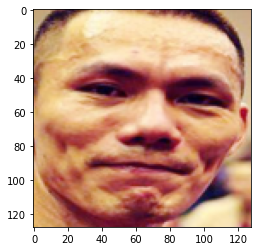

VN-celeb/46/5.png


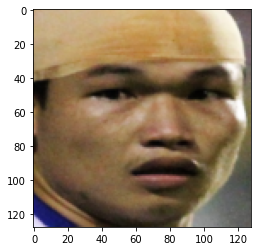

VN-celeb/893/5.png


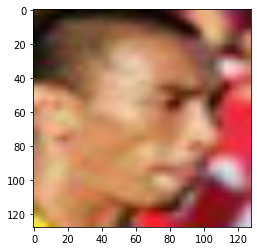

VN-celeb/820/5.png


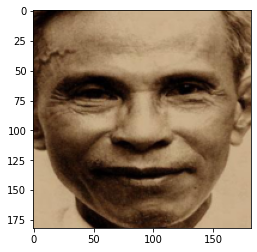

VN-celeb/33/5.png


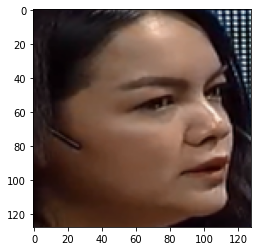

VN-celeb/891/26.png


In [7]:
import matplotlib.pyplot as plt
import cv2
data_dir = "VN-celeb"
for person in os.listdir(data_dir)[0:5]:
    for face in os.listdir(os.path.join(data_dir, person))[0:1]:
      img_path = os.path.join(data_dir, person, face)
      img = cv2.imread(img_path)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()
      print(img_path)

Yêu cầu: Lập trình một từ điển, trong đó key là id của những người trong bộ VN-celeb, value là số ảnh cho mỗi người, sau đó sắp xếp từ điển đó theo thứ tự số ảnh tăng dần

In [9]:
import operator
data_dir = "VN-celeb"
data_stats = dict()

# YOUR CODE HERE
for person in os.listdir(data_dir):
  temp = os.listdir(os.path.join(data_dir, person))
  data_stats.update({person:len(temp)})

sorted_dict = {}
sorted_keys = sorted(data_stats, key=data_stats.get)
for w in sorted_keys:
    sorted_dict[w] = data_stats[w]

data_stats = sorted_dict

# YOUR CODE HERE

In [10]:
data_stats

{'687': 2,
 '970': 2,
 '644': 2,
 '444': 2,
 '37': 2,
 '599': 2,
 '756': 2,
 '589': 3,
 '1002': 3,
 '456': 3,
 '586': 3,
 '713': 3,
 '116': 3,
 '769': 3,
 '186': 3,
 '148': 3,
 '418': 3,
 '317': 3,
 '197': 3,
 '469': 3,
 '195': 3,
 '704': 3,
 '225': 3,
 '880': 3,
 '864': 3,
 '846': 3,
 '960': 3,
 '876': 3,
 '641': 3,
 '208': 4,
 '273': 4,
 '249': 4,
 '492': 4,
 '607': 4,
 '281': 4,
 '808': 4,
 '251': 4,
 '797': 4,
 '112': 4,
 '291': 4,
 '334': 4,
 '287': 4,
 '87': 4,
 '821': 4,
 '449': 4,
 '43': 4,
 '505': 4,
 '289': 4,
 '391': 4,
 '5': 4,
 '988': 4,
 '933': 5,
 '3': 5,
 '767': 5,
 '304': 5,
 '258': 5,
 '969': 5,
 '187': 5,
 '743': 5,
 '803': 5,
 '172': 5,
 '516': 5,
 '41': 5,
 '630': 5,
 '52': 5,
 '340': 5,
 '468': 5,
 '734': 5,
 '852': 5,
 '23': 5,
 '575': 5,
 '613': 5,
 '798': 5,
 '1008': 5,
 '791': 5,
 '835': 5,
 '694': 5,
 '709': 5,
 '895': 5,
 '665': 5,
 '360': 5,
 '977': 5,
 '600': 5,
 '830': 5,
 '898': 6,
 '551': 6,
 '890': 6,
 '996': 6,
 '956': 6,
 '322': 6,
 '735': 6,
 '178':

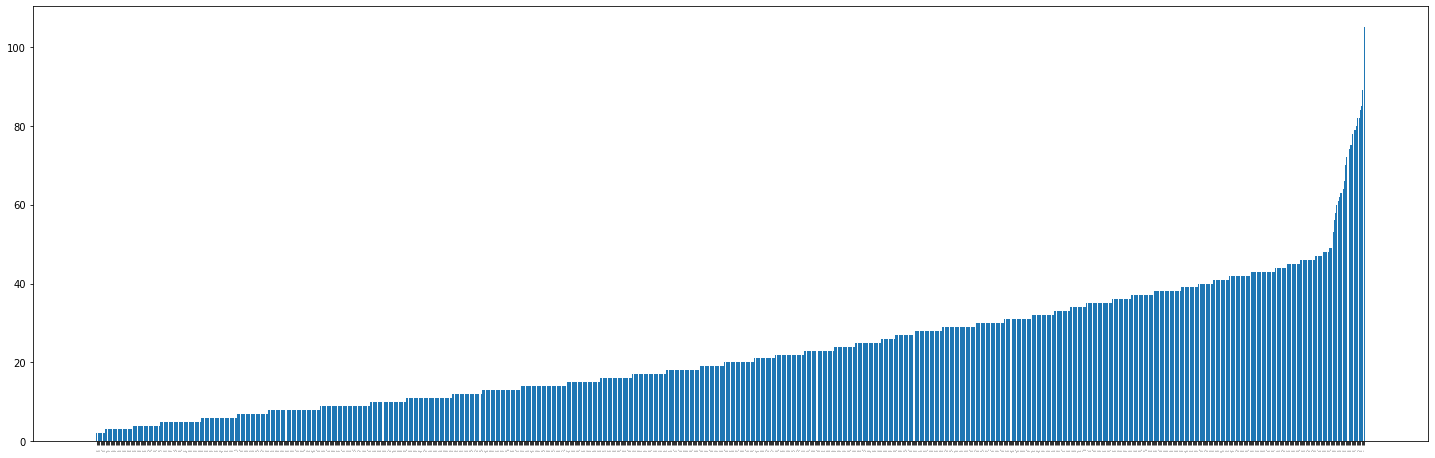

In [11]:
labels = list(data_stats.keys())
import matplotlib.pyplot as plt
plt.figure(figsize = (25,8))
plt.bar(range(len(data_stats.values())), list(data_stats.values()))
plt.xticks(range(len(labels)), labels=labels, rotation=90, fontsize=1)
plt.show()

Tiếp theo, hãy lập trình để:
- Tìm ra số người trong bộ Vn-Celeb
- Tìm ra số ảnh trong bộ Vn-Celeb
- Tìm ra người có nhiều ảnh nhất trong bộ data này
- Tìm ra người có ít ảnh nhất trong bộ data này

In [12]:
# YOUR CODE HERE
data_dir = "VN-celeb"
numOfpeople = len(os.listdir(data_dir))
numOfimage  = 0
imageEachperson = []
print("Số người trong bộ dataset này là ", numOfpeople)
for person in os.listdir(data_dir):
  numOfimage = numOfimage + len(os.listdir(os.path.join(data_dir, person)))
  imageEachperson.append(len(os.listdir(os.path.join(data_dir, person))))
print("Số ảnh trong bộ dataset này là ", numOfimage)
maxImage = max(imageEachperson)
minImage = min(imageEachperson)
#       plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#       plt.show()
#       print(img_path)

for id, value in data_stats.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
  if value == maxImage:
    print("Người có ảnh nhiều nhất trong bộ dataset này là ", id, " với số ảnh là ", maxImage)  
  if value == minImage:
    print("Người có ảnh ít nhất trong bộ dataset này là ", id, " với số ảnh là ", minImage) 


# YOUR CODE HERE

Số người trong bộ dataset này là  1020
Số ảnh trong bộ dataset này là  23105
Người có ảnh ít nhất trong bộ dataset này là  687  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  970  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  644  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  444  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  37  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  599  với số ảnh là  2
Người có ảnh ít nhất trong bộ dataset này là  756  với số ảnh là  2
Người có ảnh nhiều nhất trong bộ dataset này là  204  với số ảnh là  105


Như ta thấy, mặc dù có nhiều ảnh, nhưng bộ data này cũng có rất nhiều nhãn và giữa các nhãn có sự mất cân bằng khá lớn. Vì vậy, khi chia dữ liệu để training và testing ta cần chú ý

### 2.2. Làm quen với thư viện
Đầu tiên, ta sẽ làm quen một chút với thư viện pytorch-insightface

In [13]:
import torch
from imageio import imread
from torchvision import transforms
import insightface

# Khởi tạo đối tượng model Resnet trong với pretrained weight
embedder = insightface.iresnet100(pretrained=True)
# Gọi phương thức `eval()` để chuyển model sang chế độ inference
embedder.eval()

# Tiền xử lý dữ liệu trước khi đưa vào mô hình
mean = [0.5] * 3
std = [0.5 * 256 / 255] * 3


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Đọc và xử lý ảnh để tương thích với đầu vào của mạng
face = cv2.imread('VN-celeb/383/11.png')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (112,112))

tensor = preprocess(face)

# Thử sử dụng mạng để trích chọn thuộc tính
with torch.no_grad():
    features = embedder(tensor.unsqueeze(0))[0]

# Quan sát vector đầu ra của mạng
print(features.shape)
print(features)

Downloading: "https://sota.nizhib.ai/insightface/iresnet100-73e07ba7.pth" to /root/.cache/torch/hub/checkpoints/iresnet100-73e07ba7.pth



torch.Size([512])
tensor([ 6.0308e-01,  1.2422e-01, -6.8833e-01,  1.8287e+00, -3.1607e-01,
         3.2813e-01, -3.0018e-01, -9.4098e-02, -2.3844e-02,  2.1633e-01,
         5.6473e-01, -2.3133e-01, -1.3760e+00,  9.7392e-01, -6.9291e-01,
         7.2052e-02, -1.0376e-01,  1.4675e-01,  1.1886e+00,  4.8358e-01,
        -7.6243e-01, -1.8547e-01,  2.0508e-01, -1.5928e+00, -1.8578e-02,
         1.1344e-01, -9.0787e-01,  1.7962e-01, -8.4547e-01,  1.1433e-01,
        -1.1875e+00, -1.6705e+00,  1.7894e-01,  2.2042e-01, -2.6922e-01,
         1.6600e-01, -1.6075e-01,  1.6296e-01,  3.5146e-01,  1.1484e-01,
         7.2251e-01,  1.7968e+00, -8.3894e-01, -9.3564e-01, -8.2832e-01,
        -7.3509e-01, -4.1660e-01,  3.2390e-02, -7.2582e-01,  7.9661e-01,
        -1.1169e+00, -3.9248e-01, -3.2347e-01,  4.9698e-01, -5.7229e-01,
        -7.4288e-01, -1.2623e-01, -7.2858e-01, -6.5530e-02,  7.8892e-01,
         2.2258e-01, -1.6004e-01, -8.1951e-01,  8.1167e-01,  1.0432e+00,
         2.8422e-01,  3.2394e-01

Ta thấy đầu ra của mạng sẽ là một vector 512 chiều, ta có thể sử dụng vector này làm đầu vào cho một bộ phân loại nào đó

## Bước 3: Trích chọn thuộc tính
Hãy đọc dữ liệu vào notebook và lưu vào hai biến sau:
- Các ảnh vào list `faces` 
- Các nhãn vào list `ids`

Lưu ý: Khi đọc ảnh, ta phải có một bước convert ảnh từ không gian màu BGR sang RGB, và chuyển về size (112,112).

In [33]:
faces = []
ids = []

# YOUR CODE HERE
dir1 = os.listdir(data_dir)
for person in dir1:
  dir2 = os.listdir(os.path.join(data_dir, person))
  for face in dir2:
    img_path = os.path.join(data_dir, person, face)
    face1 = cv2.imread(img_path)
    face1 = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)
    face1 = cv2.resize(face1, (112,112))
    faces.append(face1)
    ids.append(person)
    # plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    # plt.show()
    # print(img_path)

# YOUR CODE HERE

In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

In [35]:
# Tách dữ liệu thành tập train và test
X_train, X_test, Y_train, Y_test = train_test_split(faces, ids, test_size = 0.2, stratify = ids, random_state = 42)

Lập trình hàm `feature_extraction` để trích chọn thuộc tính cho ảnh thông qua model resnet trong insightface. Các tham số gồm có:

- X: danh sách hoặc array chứa các ảnh cần biến đổi
- use_cuda (True/False): Nếu True, ta sẽ chạy mô hình với GPU

Đầu ra sẽ là danh sách hoặc array chứa những vector thuộc tính tương ứng với các ảnh

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [36]:
# Optional: Dùng thư viện tqdm để theo dõi tiến trình xử lý dữ liệu
from tqdm import tqdm
embedder = insightface.iresnet100(pretrained=True)
embedder.to(device)
# Gọi phương thức `eval()` để chuyển model sang chế độ inference
embedder.eval()

def feature_extraction(X, use_cuda =True):
  X_transformed = []
  
  # YOUR CODE HERE
  for face in tqdm(X, position=0, leave=True):
    tensor = preprocess(face).to(device)
    with torch.no_grad():
      features = embedder(tensor.unsqueeze(0))[0]
    X_transformed.append(features)
  return X_transformed
  
  # YOUR CODE HERE

In [37]:
X_train_features = feature_extraction(X_train)

100%|██████████| 18484/18484 [04:22<00:00, 70.43it/s]


In [38]:
X_test_features = feature_extraction(X_test)

100%|██████████| 4621/4621 [01:05<00:00, 70.71it/s]


## Bước 4: Xây dựng mô hình
Ở đây, ta sẽ sử dụng bộ phân lớp SVM tính toán. Tuy nhiên, ta hoàn toàn có thể thay đổi tham số hoặc sang một mô hình phù hợp hơn với dữ liệu

In [39]:
from sklearn.linear_model import SGDClassifier 

In [41]:
X_train_features_new = [t.to('cpu').numpy() for t in X_train_features]
X_test_features_new = [t.to('cpu').numpy() for t in X_test_features]

In [42]:
model = SGDClassifier()
model.fit(X_train_features_new, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
model.score(X_train_features_new, Y_train)

0.9520125513958018

In [44]:
model.score(X_test_features_new, Y_test)

0.7753732958234149